# Assignment 2: Perceptrons
Anthony Martin P. Navarez, CMSC 173 - A  
### 1. There’s something wrong with my setup that causes our perceptron method to fail. Can you adjust the perceptron method to make sure it runs?
To fix the error in the code, I have changed the initialized size for weights (type list) to the number of input features (```weights = [0 for _ in range(len(dataset[0]))]```). This is because a trained perceptron has weights corresponding to every feature indicated in the training dataset as shown in the image below:

![Perceptron Image](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F3354%2F1*7pwA1DjBw6JDkwZQecUNiw.png&f=1&nofb=1)

Thus the line ```weights[k] = weights[k] + current_labels[i] * item[k]``` now works as ```weights``` and ```items``` have the same number of elements.

### 2. On line 33, why do we need to check for ```activation * current_labels[i] <=0``` instead of just ```activation * current_labels[i] < 0 ?```

Following the formula ya <= 0, it ensures that there is a binary classification by taking 0 into consideration. 0 in this context means no prediction, hence it is also considered as an incorrect prediction.

### 3. What were we trying to do from line 25 to line 27? Why did we need to do that?

The lines are duplicating the contents of ```dataset``` and ```y_labels```. Python uses the Passing-by-Object-Reference principle in functions. This means that any variable within the function that holds or is initialized directly to any mutable argument (e.g. lists) does not copy the contents of that object (since in Python everything is considered as an object) but holds an address reference to it. Hence when there are changes on that arguments or variables with the same reference to it, the original values outside of the function will be mutated as well. Duplicating through the method used in the code or functions such as ```deepcopy()``` preserves the orignal values, which is important as they may be used by other methods. [This segment shows what I mean.](#deepcopying)

### 4. Finally, if we changed up my ```max_iterations``` from 2, do you think we could do a better job? Could you describe this in terms of underfitting and overfitting?
There is a high probability that the performance of the perceptron would improve if we increase the max iterations/epochs. This is because we are allowing the perceptron to further train itself with the training data, which would intuitively lead to overfitting as the epochs become greater. We would expect that the errors would decrease and eventually plateau, however, [the graph shown in the blocks below](#performance) does not show a smooth decrease in the errors as in Hal Daume's book. This may be because of the line ```random.shuffle(joined_x_and_y)``` that the book also claims to improve the performance of the book, which I consider to be preventing the perceptron to also memorize the ordering of the training data. On the other hand, there seems to be less to no risk of underfitting within this model.

### References
- https://stackoverflow.com/questions/13299427/python-functions-call-by-reference
- https://i-sapna.com/python-pass-by-object-reference/
- http://ciml.info/

In [1]:
"""
Sonar data is from: https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/
"""

import random
import csv
from decimal import Decimal
import matplotlib.pyplot as plt


def perceptron(dataset, y_labels, max_iterations):
    """
    You may assume here that dataset is a 2-dimensional array
    of figures. There is no header row and so all of the items inside
    dataset is numerical in nature, so they are immediately pluggable.
    You may assume that the dataset is correctly cleaned and
    that there are no anomalies in the dataset.
    y_labels consists of the correct labels for each example in
    the dataset and so you may assume that there are the same
    number of entries in y_labels as there are in dataset.
    The goal of this perceptron algorithm is to return the
    updated array of weights and the bias term.
    """
#     changed the weights list size since size of weights correspond to the number of features
    weights = [0 for _ in range(len(dataset[0]))]
    bias_term = 1
    """
    Duplicating the dataset and y_labels lists.
    Similar to copy constructors, this duplicates the contents of a list only.
    When there are changes on the original list or the copied list, either one would not be mutated.
    The original list values may be used later, thus preserving it is important.
    """
    current_dataset = [*dataset]
    current_labels = [*y_labels]
    
    for iteration in range(max_iterations):
        joined_x_and_y = list(zip(current_dataset, current_labels))
        random.shuffle(joined_x_and_y)
        current_dataset, current_labels = zip(*joined_x_and_y)
        for i, item in enumerate(current_dataset):
            activation = 0
            for j, value in enumerate(item):
                activation = activation + weights[j] * item[j]
            activation += bias_term
            """
            Follows the formula ya <= 0. Ensures that there is a binary classification
            by taking 0 into consideration. 0 in this context means no prediction, hence
            it is also considered as an incorrect prediction.
            """
            if activation * current_labels[i] <= 0:
                for k, weight in enumerate(weights):
#                     fixed since weights and items/features have the same number
                    weights[k] = weights[k] + current_labels[i] * item[k]
                bias_term = bias_term + current_labels[i]

    return weights, bias_term

In [2]:
file_path = './sonar.data'
LABELS_CONSTANTS = {'R': -1, 'M': 1}

with open(file_path, 'r') as file:
    dataset = []
    y_labels = []
    csv_reader = csv.reader(file)
    for row in csv_reader:
        if not row:
            continue
        dataset.append([Decimal(item) for item in row[:-1]])
        y_labels.append(LABELS_CONSTANTS[row[len(row) - 1]])
        
# weights, bias = perceptron(dataset, y_labels, 2)
# print(weights, bias)

In [3]:
def predict_add_bias_once(test_point, weights, bias):
    total = 0
    for i, x in enumerate(test_point):
        total += test_point[i] * weights[i] 
    total += bias

    if total > 0:
        return 1
    else:
        return -1

# the original function in the code
def predict(test_point, weights, bias):
    total = 0
    for i, x in enumerate(test_point):
        total += test_point[i] * weights[i] + bias

    if total > 0:
        return 1
    else:
        return -1

In [4]:
def zero_one_score(dataset, y_labels, weights, bias, add_bias_once):
    """
    returns the percentage of incorrect classifications
    """
    score = 0
    if add_bias_once:
        for i, item in enumerate(dataset):
            if predict_add_bias_once(item, weights, bias) != y_labels[i]:
                score += 1
    else:
        for i, item in enumerate(dataset):
            if predict(item, weights, bias) != y_labels[i]:
                score += 1

            
    return score/len(dataset)

<a id="performance"></a>
## Two ways of adding bias - Performance

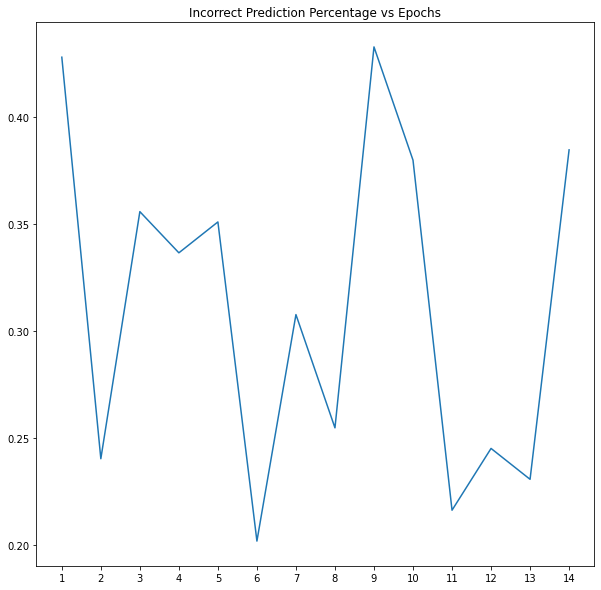

In [5]:
# checking for improvements by increasing the maxIter
zero_one_val = []

for i in range(1,15):
    weights, bias = perceptron([*dataset], [*y_labels], i)
#     add bias term only once
    zero_one_val.append(zero_one_score(dataset, y_labels, weights, bias, True))
    
plt.figure(figsize=(10,10))
plt.plot(zero_one_val)
plt.xticks([i for i in range(0,14)], [i for i in range(1,15)])
plt.title('Incorrect Prediction Percentage vs Epochs')
plt.show()

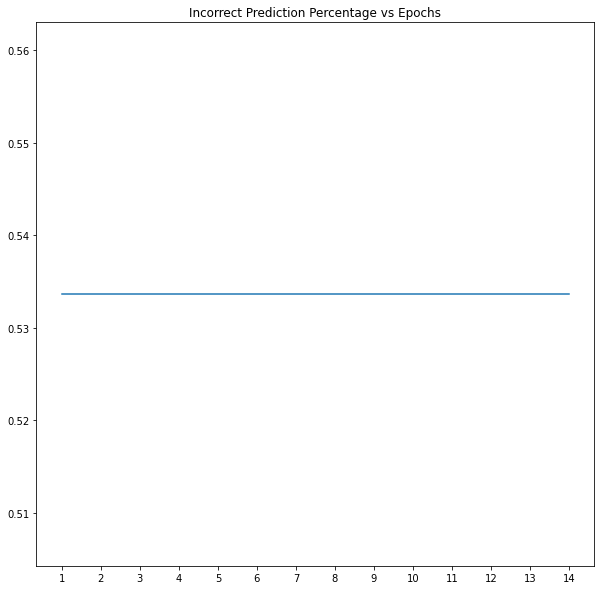

In [10]:
# checking for improvements by increasing the maxIter
zero_one_val = []

for i in range(1,15):
    weights, bias = perceptron([*dataset], [*y_labels], i)
#     add bias term everytime
    zero_one_val.append(zero_one_score(dataset, y_labels, weights, bias, False))
    
plt.figure(figsize=(10,10), facecolor='white')
plt.plot(zero_one_val)
plt.title('Incorrect Prediction Percentage vs Epochs')
plt.xticks([i for i in range(0,14)], [i for i in range(1,15)])
plt.show()

<a id="deepcopying"></a>
## Appendix: Duplicating and Python's Passing-by-Object-Reference

In [7]:
"""
Demonstrating Python's Passing-by-Object-Reference
"""

original_list = [0, 1, 2, 3]

def append_173(list_arg):
    # printing the address of list_arg
    print(list_arg, id(list_arg))
    
    # assigning list_arg to another variable
    list_holder = list_arg
    print(list_holder, id(list_holder))
    
    # appending 173 to list
    list_holder.append(173)

append_173(original_list)
# printing the post-function values of original_list 
print(original_list, id(original_list))

[0, 1, 2, 3] 140268428990720
[0, 1, 2, 3] 140268428990720
[0, 1, 2, 3, 173] 140268428990720


In [8]:
"""
Demonstrating duplication
"""

original_list_2 = [0, 1, 2, 3]

def append_173_with_duplication(list_arg):
    # printing the address of list_arg
    print(list_arg, id(list_arg))
    
    # assigning list_arg to another variable
    list_holder = [*list_arg]
    
    # appending 173 to list
    list_holder.append(173)
    print(list_holder, id(list_holder))
    
append_173_with_duplication(original_list_2)
# printing the post-function values of original_list 
print(original_list_2, id(original_list_2))

[0, 1, 2, 3] 140268428987136
[0, 1, 2, 3, 173] 140268394184896
[0, 1, 2, 3] 140268428987136
